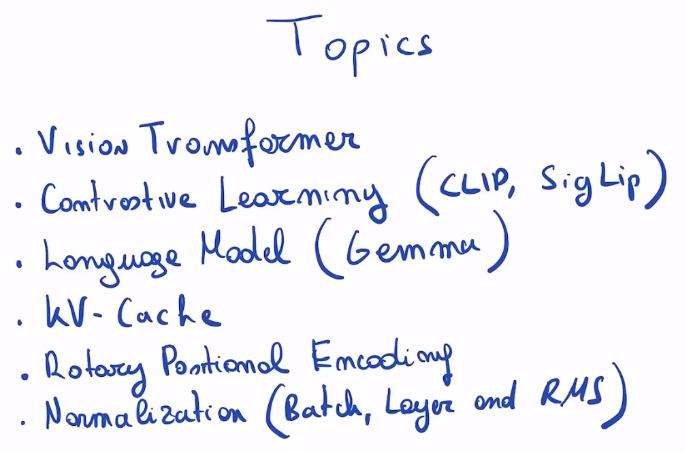

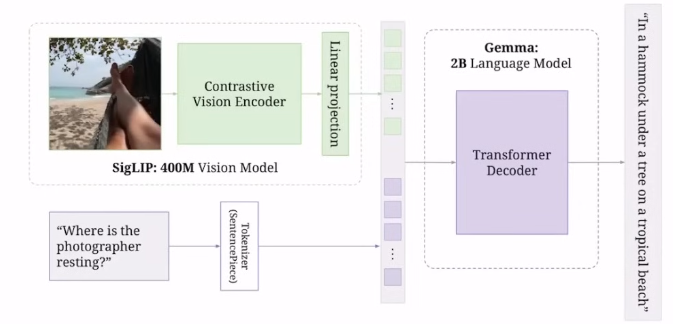

# Contrastive learning
- Dot product should give high value for the matching image-text pair (blue square) and low value for the unmatch (white)


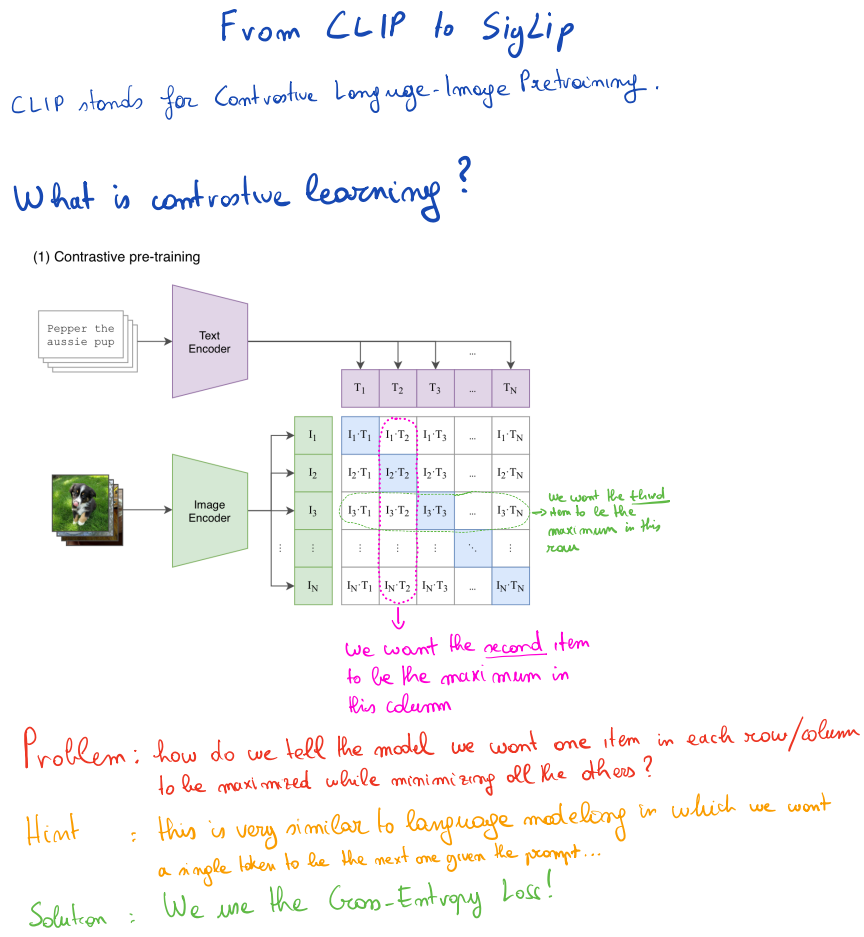

## Pseudo code

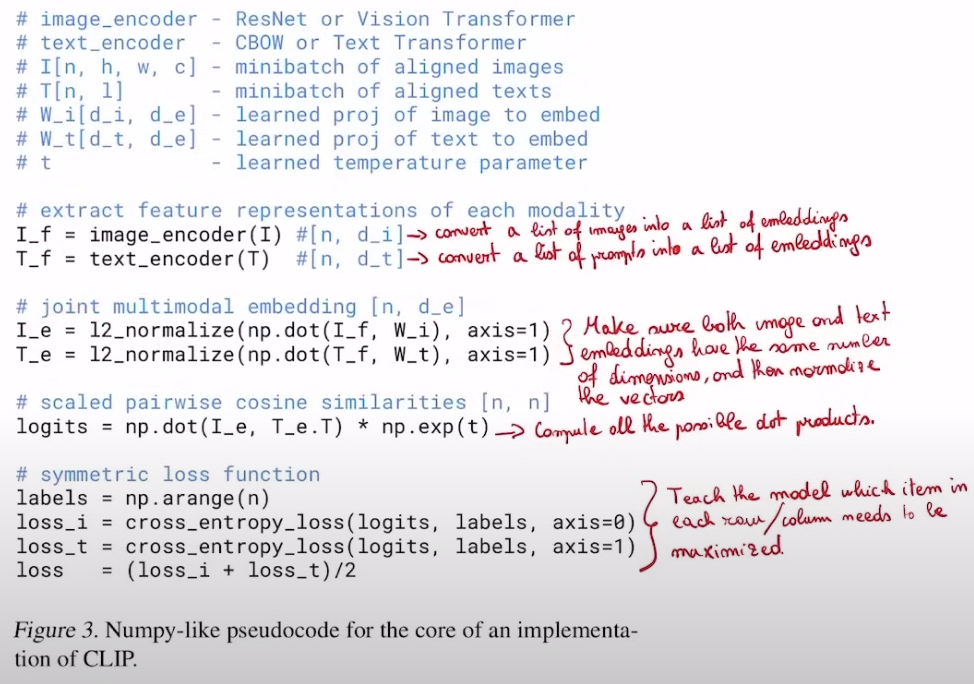

## Problem with CLIP (softmax)
- With softmax, we force the model to generate a distribution across all tokens
- Match pair should have highest value **across its row and column**

### Numerically stability of softmax
- Exponential grows very fast ==> we need to make it more numerically stable
- We need to calculate the exponential of all items in that row/column
- 

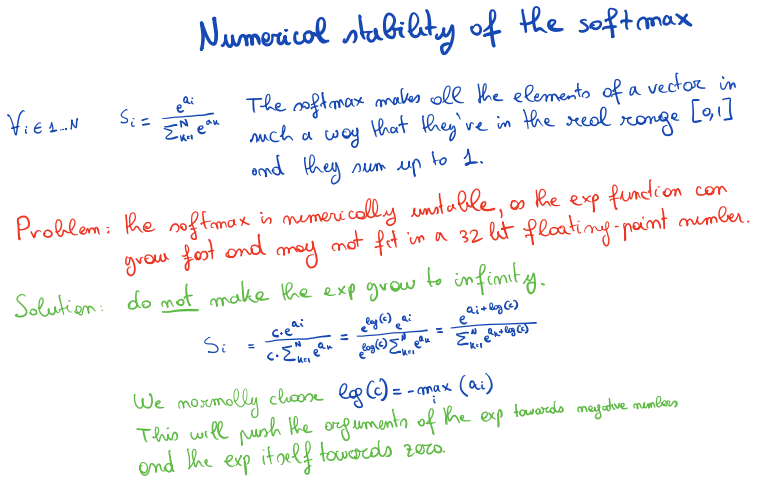

### Computation problem with softmax

- Since each computation requires access to all items in one row/column, we need to put a whole row/column into memory of a device => make it hard to parallel
- Softmax matrix is asymmetry: across images and across texts ==> very computationally expensive

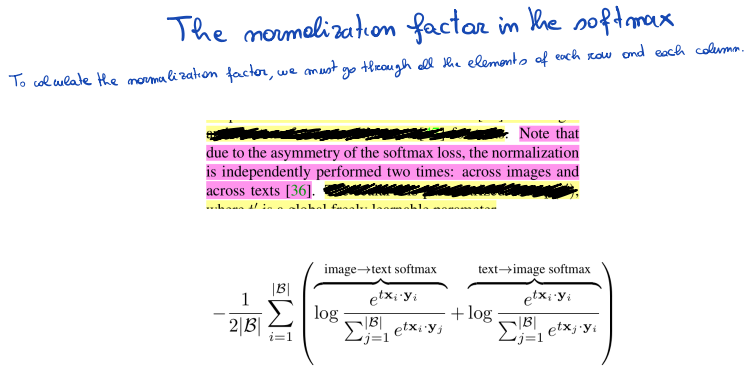

## Solution: use Sigmoid instead of Softmax

Instead of treating the loss as ***distribution over each row/column***, we calculate independently for each dot product
- Each of the dot product becomes an independent binary classification task
- &rarr; grow batch sizes
- &rarr; parallel computation

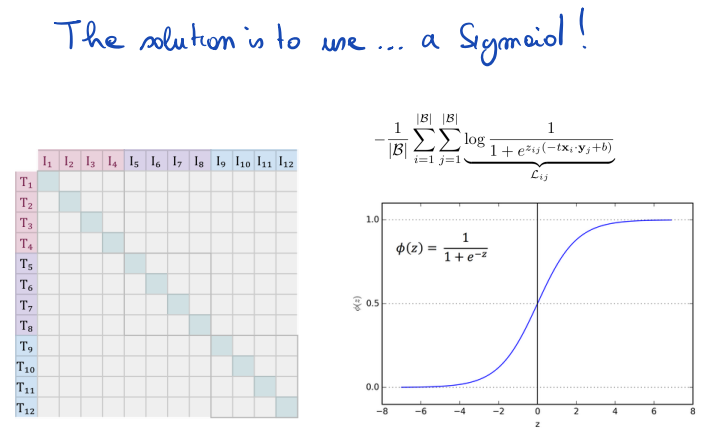

## Why we use contrastive vision encoder instead of normal vision encoder?
Because we want these embeddings to not only capture information about an image
- But we also these embeddings to be able to be contrasted and used along with the text embeddings
- &rarr; we want a vision encoder that can be used with the text

Because they are easy and cheap to train:
- Lots of images with captions from the internet &arr; we can crawl and train on them 

# Normalization

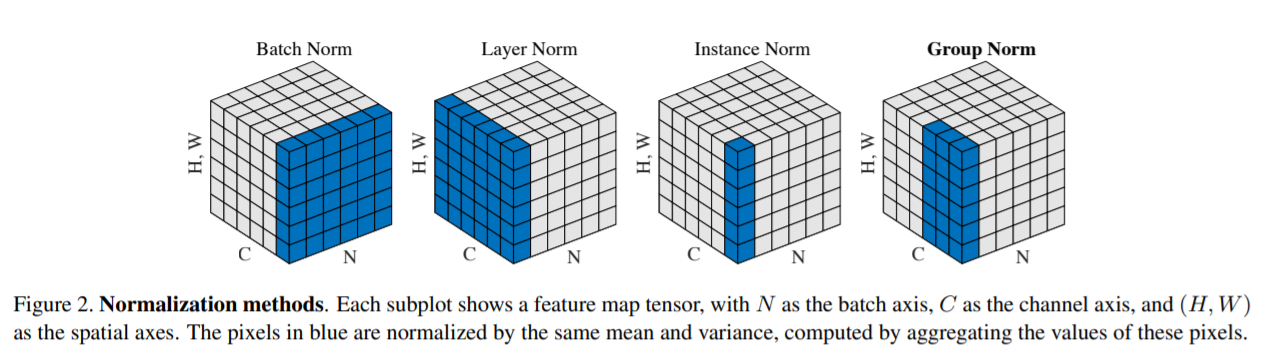

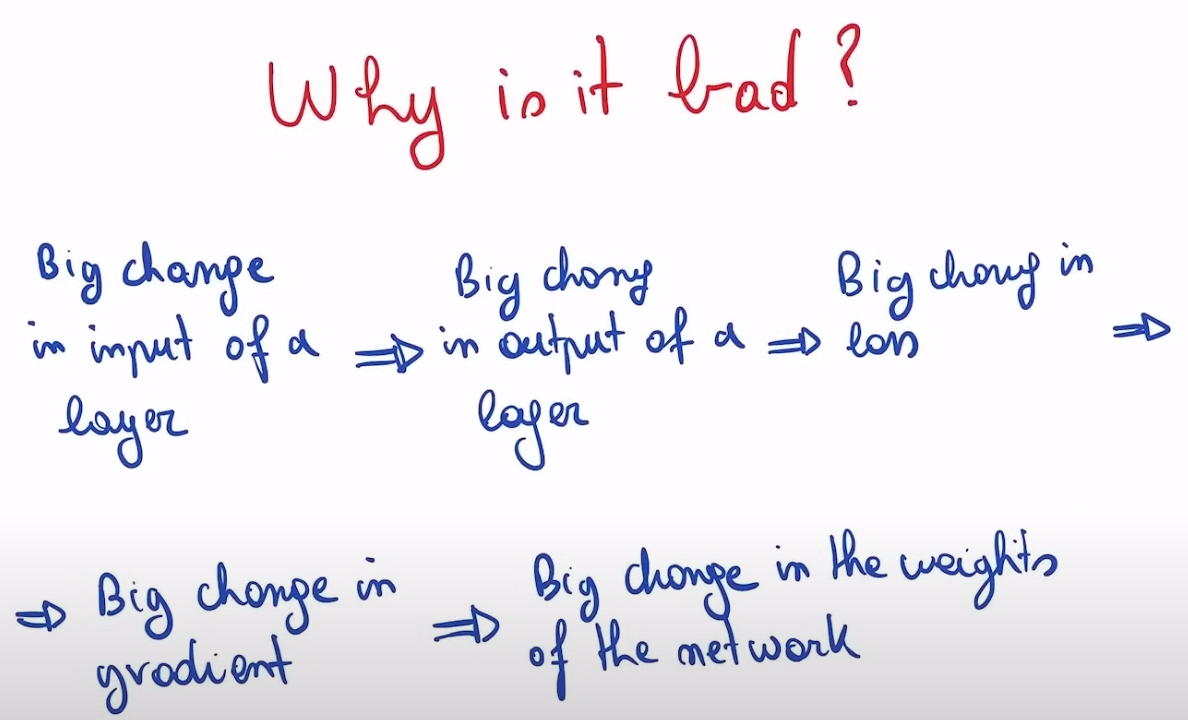

## Motivation (covariate shift)

- When input change from one batch to another (magnitude change) &rarr; the output will also change in magnitude
- output change &rarr; loss change
- loss change &rarr; gradient change
- gradient change &rarr; updating the weight change
- &rarr; loss oscillate a lot
- &rarr; weight try to keep up with these changing in input distribution
- &rarr; model train slowly

## Batch norm

Why we need it:
- Image of a cat is very different from image of a dog (color distribution is different)
- The image change a lot &rarr; we don't want the model to feed this change in magnitude of the input
- &rarr; we want the distribution of the input to remain constant
- &rarr; the model will not oscillate

Mechanism:
- We have a batch of items as input instead of a single one
- &rarr; We calculate the statistic (mean, std) for each **dimension** of each item (across whole batch)

Result:
- The model will not see the change in magnitude and distribution because all items will be distributed according to a mean of zero and variance of 1
- &rarr; oscillate less in output, loss, gradient &rarr; weights oscillate less
- training will be more stable &rarr; converge faster

Problem of batch norm:
- statistic stats are calculated along the batch dimension
- &rarr; we are miixing the features of different items (e.g. dim1 of cat with dim1 of dog)
- &rarr; to have good result, we have to use big batch size
- &rarr; still cannot 100% solve the covariate shift problem

## Layer norm

Mechanism:
- statistic stats for each item (across all dimensions)

Result:
- each item is independent of other
- more stable

# CNN

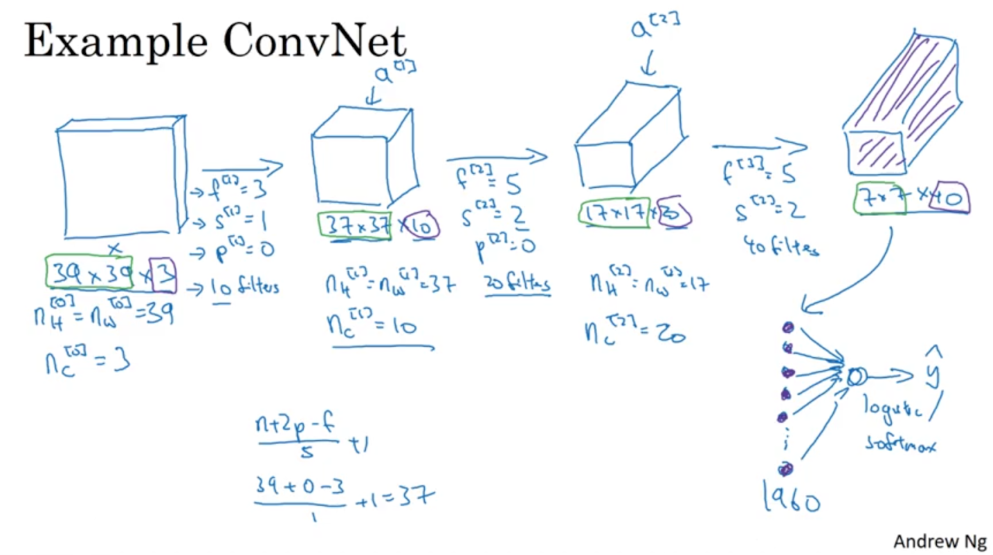

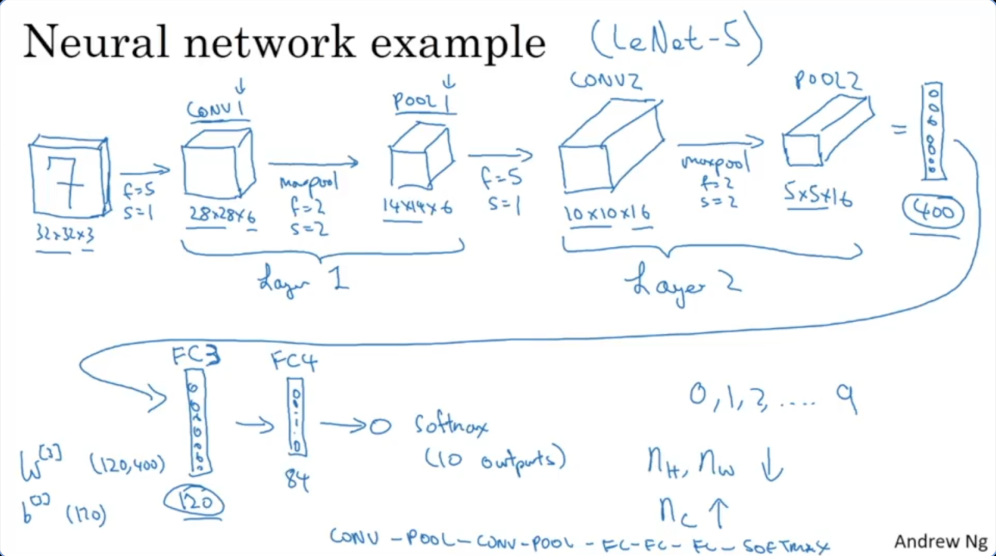

# ViT vs CNN

- CNN is local, while ViT is global
- CNN focus on local context, while ViT focus on global context (which can be bad)
- CNN is local receptive, while ViT is global receptive

# ViT vs TextT

Language model:
- Contextualize each token with all tokens come before it
- Why its powerful: it can predict each token's next token in parallel &rarr; during training, the model can be trained on how to predict the next token with only 1 forward pass 

Vision model:
- Contextualize each patch with all other patches (no matter before or after)

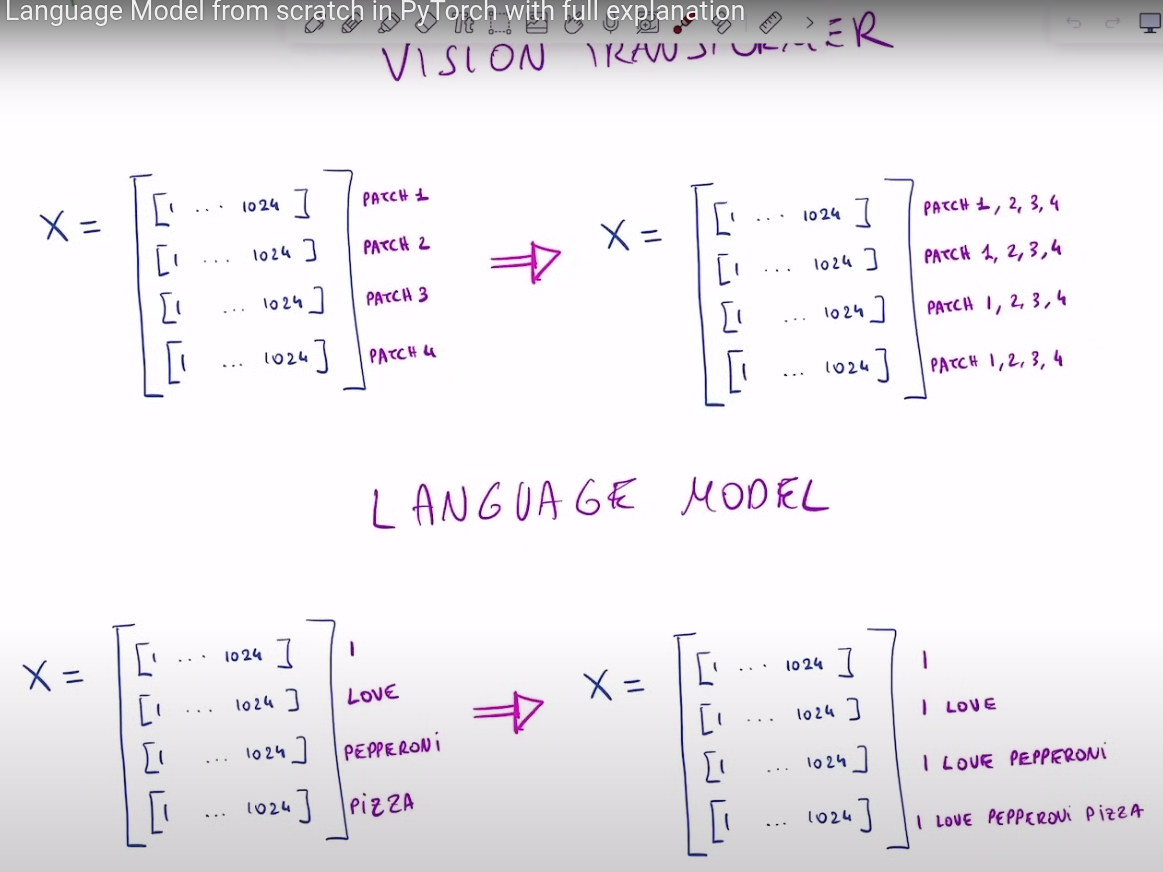

# Decoder-only Transformer


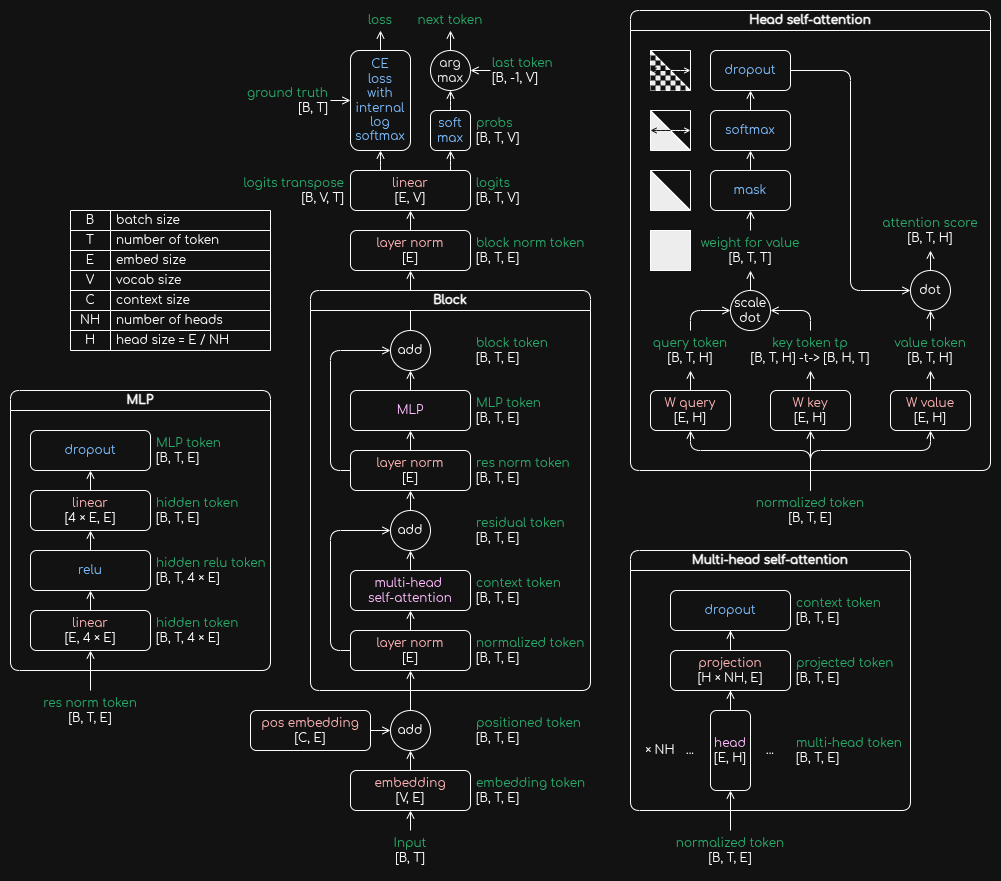

# Vision transformer

- After CNN layer, each patch gets embedding of themselves
- After transformer layer, each patch gets embedding with contextual information of other patches
- No need to mask (unlike language model)

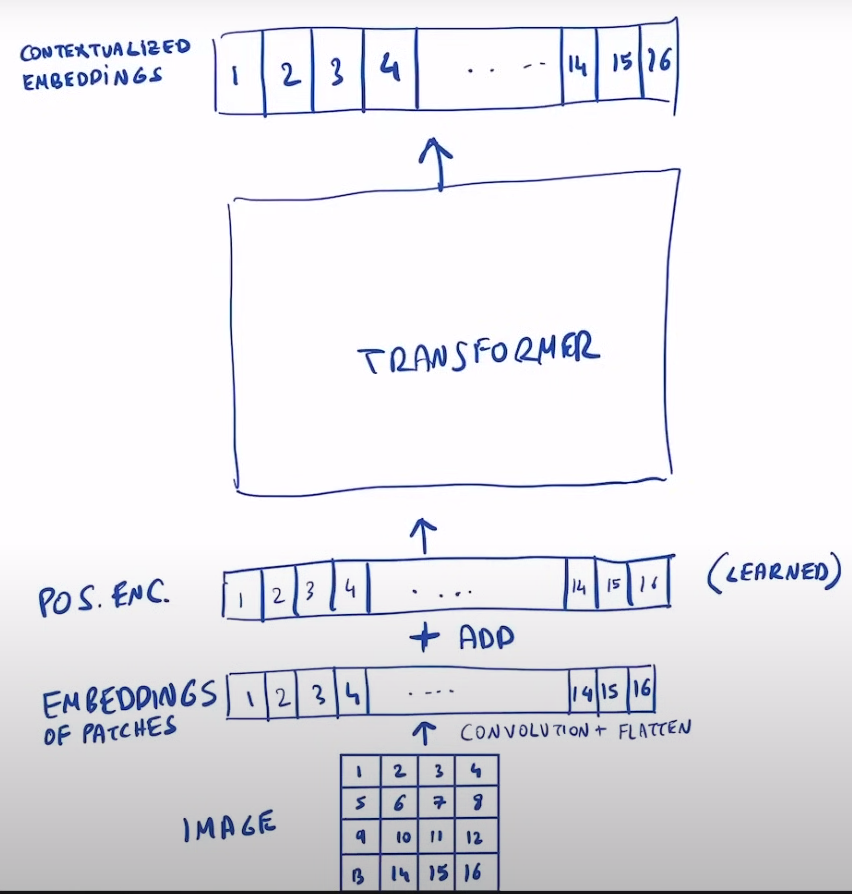

## Vision encoder

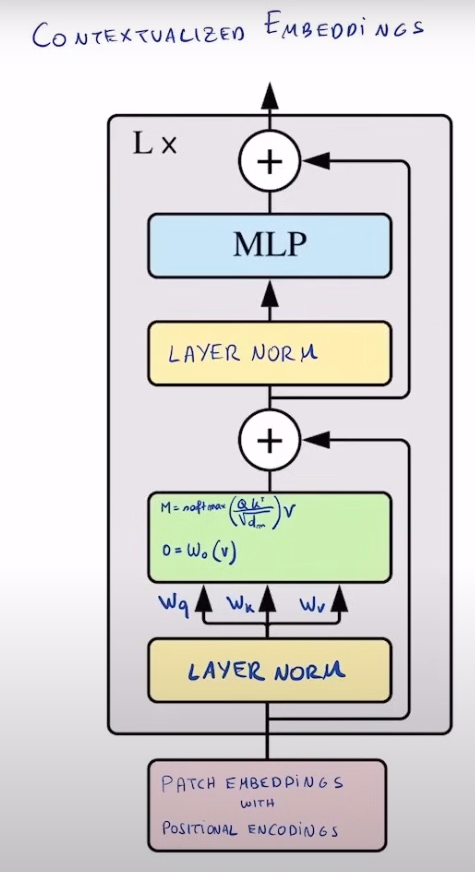

## Multi-head attention
Why:
- If we do not split &rarr; calculate 1 dot product for whole token &rarr; there's only 1 way to relate one token with others

Mechanism
- each head works with a smaller part of the embedding
- they can work independently from each other &rarr; parallel

Result:
- We learn to relate tokens to each other differently because each head is watching different part of a token
- For example (a word may has different POS, so each head relate to each token as a different POS)





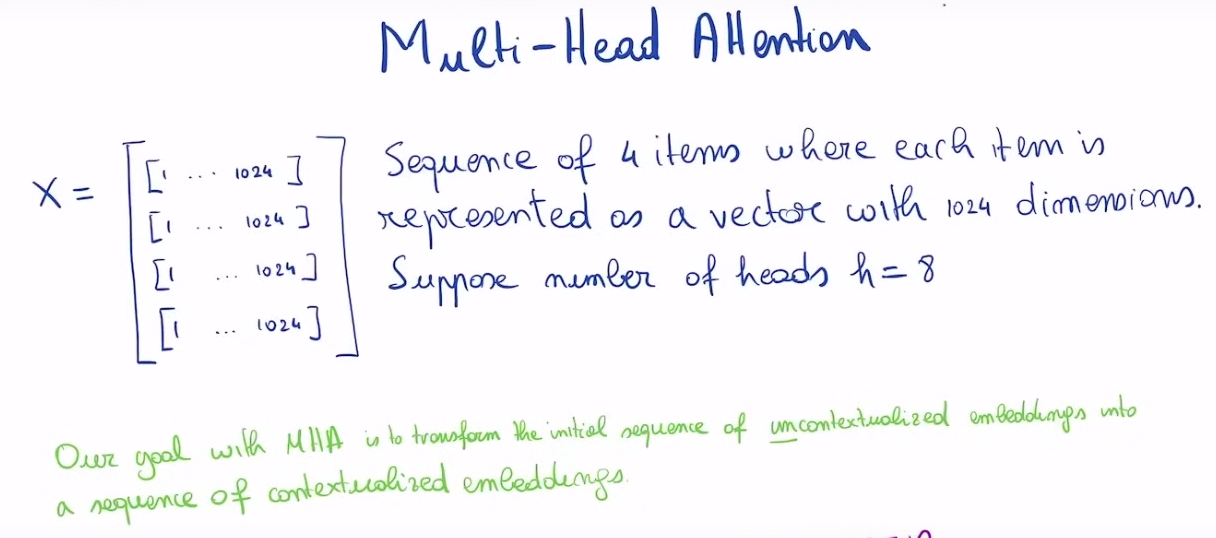

The visualization here is a little bit different from the code implementation:
- **Visualization**: divide the W into multiple heads first, then dot product
- **Implementation**: dot product first, then divide the result (Q, K, V) into multiple heads

Reason is because of grouped query attention:
- Number of heads for the query is much bigger than the number of heads for key and value

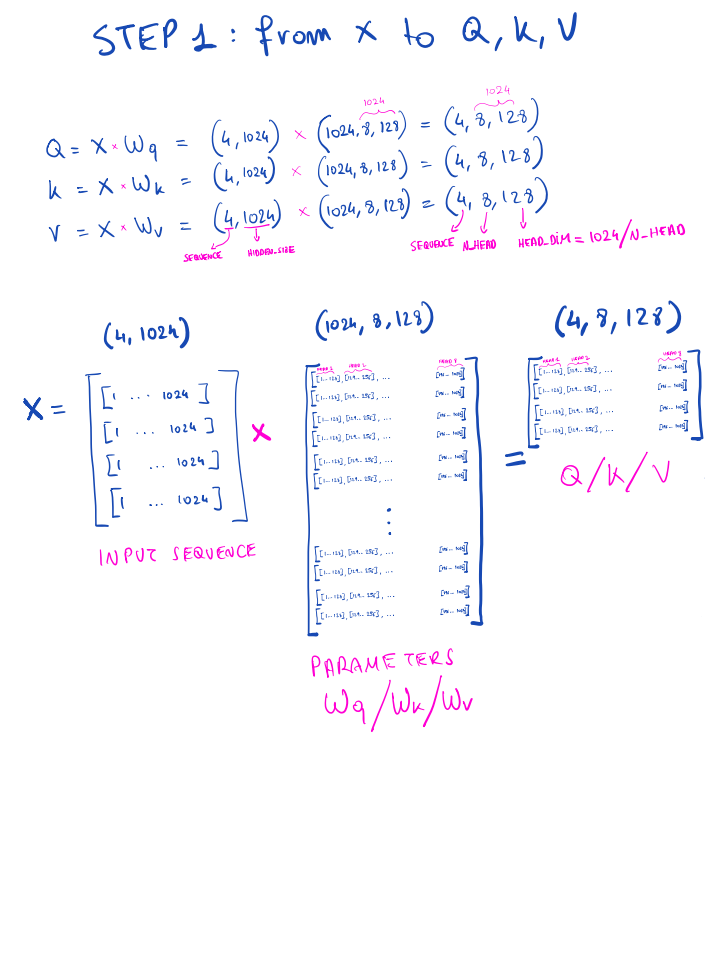
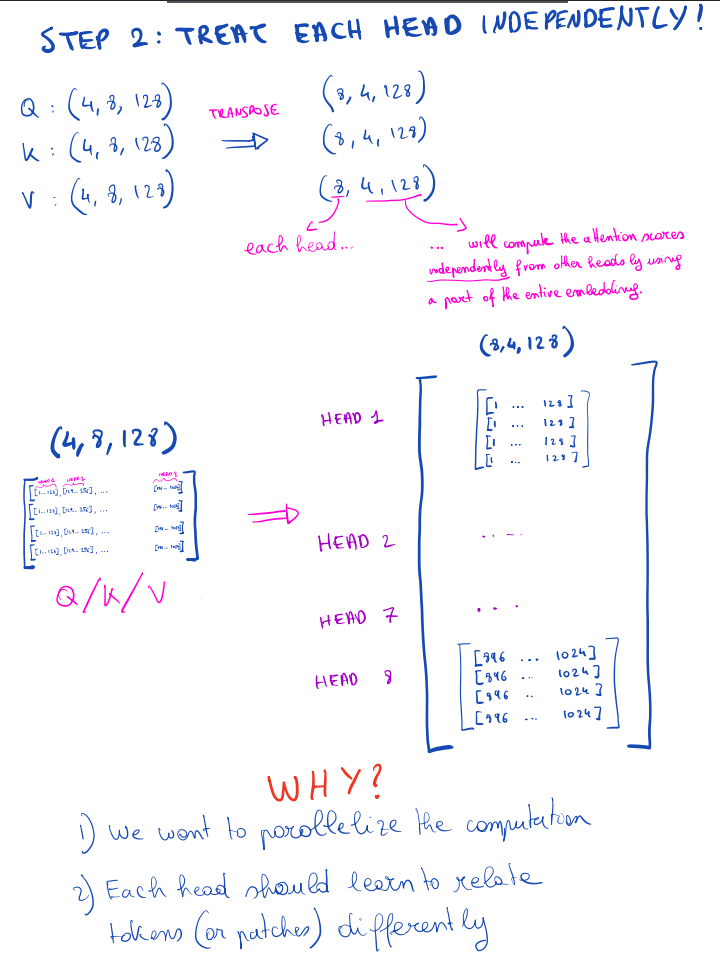


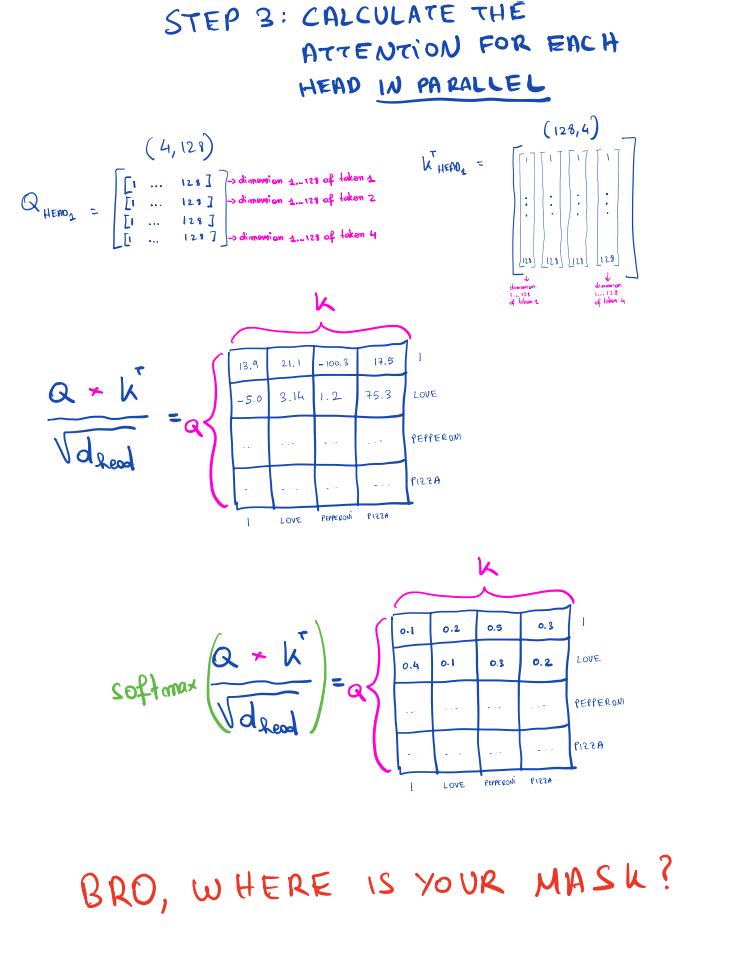
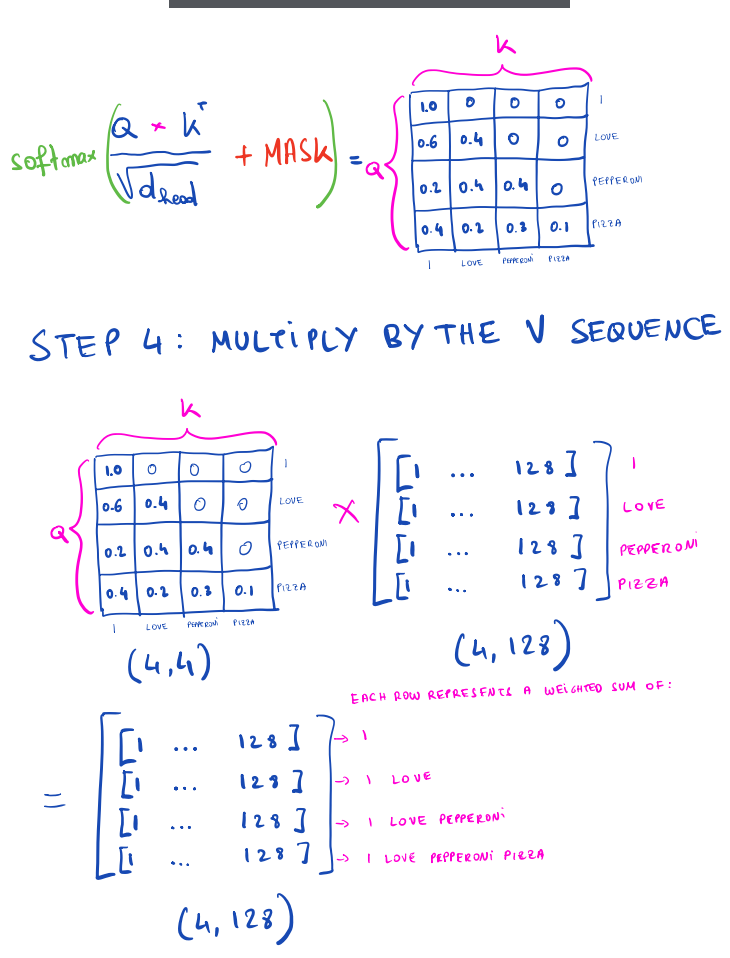


There is no mixing between these heads yet (only concatenation)
- We do the mixing by multiplying with Wo
- If we don't mix, these heads are just calculated independently

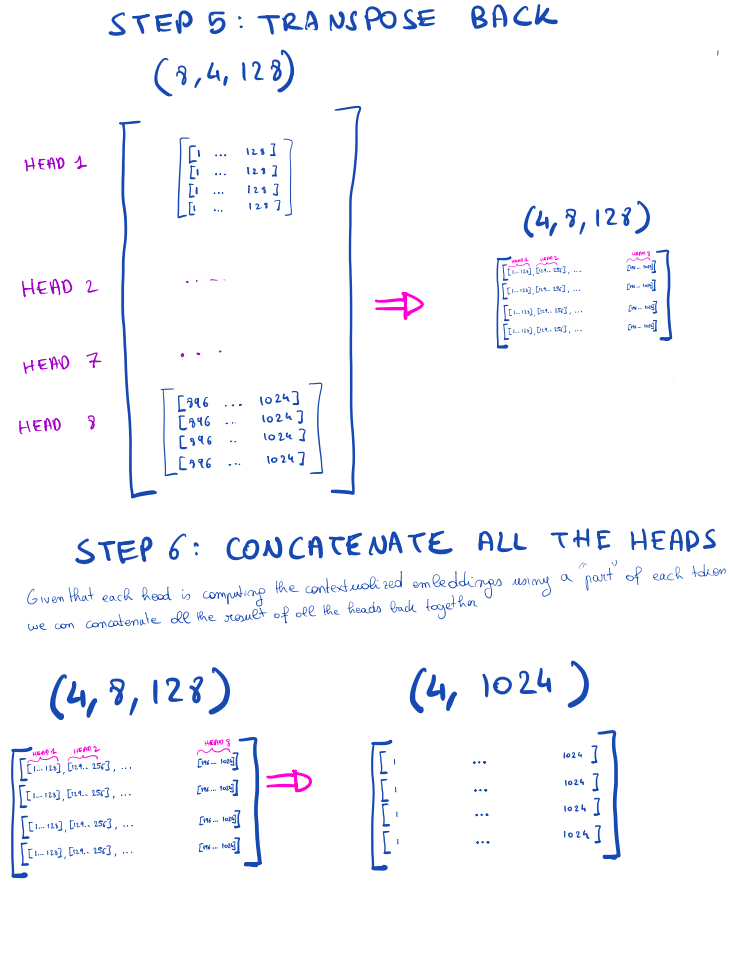
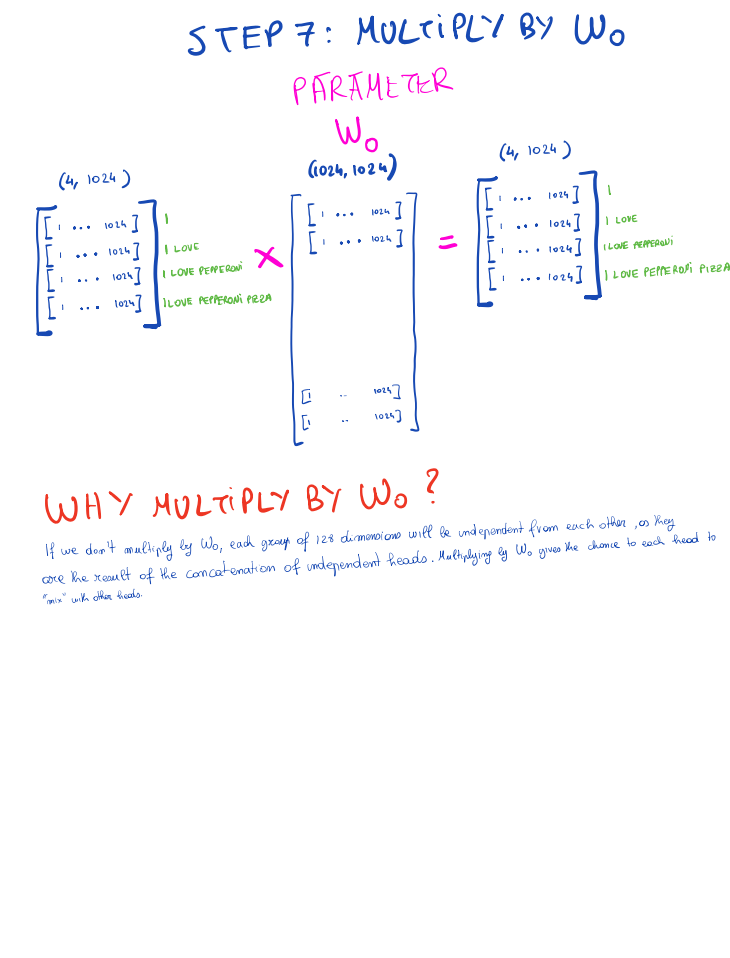

## Single embedding token

- In contrastive learning, each image only has one token as its representative
- But in the output of vision encoder, each image has num_patch token. How?
- &rarr; It can either averaging all token or take the first output token as the reprensentative token for the whole image (just like cls token in BERT) 

# PaliGemma processor
- Given text (user's prompt) and image
- Preprocess image (resize, rescale, normalize)
- Create text tokens with place holder for image tokens

# PaliGemma model


## KV cache

Why we need it:
- If we have a sequence of size T, then we will create an attention matrix of size T*T
- Is there a way to only generate the next token we need, instead of T*T
- &rarr; KV-cache
- To generate only the logits of last token, we multiply the last row of Q with the whole matrix K
- We also need the whole matrix V

Mechanism:
- Everytime we pass input to self attention, we cache the Key and Value sequence into buffer
- Two phrases:
  1. Prefilling (send key and value to cache) &rarr; we do not have to apply mask here
  2. Token generation

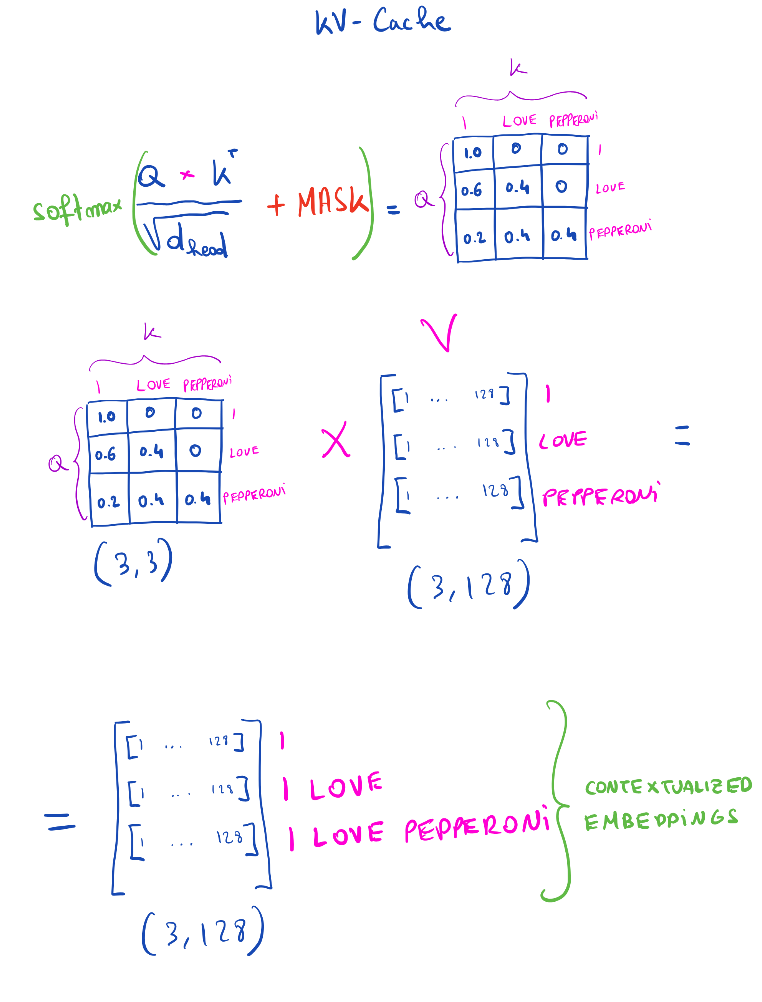

## Attention mask

- In other LLMs, the attention mask is applied for both prompt (image + text) and output during both training and inferencing time
- But in PaliGemma, attention mask is only applied for output during both training and inferencing time &rarr; input token (text prompt + image token) are not masked

Masking in Train vs inference:
- During training, we need to maskout the output since they are all generated in parallel so we need to mask out
- But during inference, we actually do not need to mask out since they are generated token by token autoregressively